# ML for Causal Inference: High-Dimensional Instruments

In [439]:
library(glmnet)
library(stats)
library(ggplot2)
library(AER)

## Example: Weak First Stage and Exclusion Restriction Violation

In [440]:
#Simulate Data
set.seed(1)
N <- 1e3 # Number of Observations
# Simulate Data for Example in Intro
weak <- rnorm(n = N)
good <- rnorm(n = N)
correl <- rnorm(n = N) 
C <- 3 * correl + rnorm(n = N)
X <- -.000001 * round(weak) + 2.5 * correl + 2.5 * good + .5 * C + rnorm(n = N)
Y <- 2.0 * X + 1.1 * C + rnorm(n = N)
df <- cbind(Y, X, correl, good, weak)
colnames(df) <- c('Y', 'X', 'correl', 'good', 'weak')
df <- data.frame(df)

In [441]:
# No Instrument, naive regression
fit.none <- lm(Y ~ X, data = df)
summary(fit.none)
X.none <- fit.none$coefficients[2]
ci.none <- confint(fit.none, 'X', level = 0.95)


Call:
lm(formula = Y ~ X, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.3707 -1.3519  0.0967  1.4833  7.1721 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.05197    0.07199   0.722    0.471    
X            2.59080    0.01440 179.964   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.276 on 998 degrees of freedom
Multiple R-squared:  0.9701,	Adjusted R-squared:  0.9701 
F-statistic: 3.239e+04 on 1 and 998 DF,  p-value: < 2.2e-16


In [442]:
# Fit using a good instrument (strong first stage and satisfies exclusion restriction)
fit.good <- ivreg(Y ~ X | good, data = df)
summary(fit.good, vcov = sandwich, df = Inf, diagnostics = TRUE)
X.good <- fit.good$coefficients[2]
ci.good <- confint(fit.good, 'X', level = 0.95)


Call:
ivreg(formula = Y ~ X | good, data = df)

Residuals:
      Min        1Q    Median        3Q       Max 
-12.17673  -2.46209  -0.01462   2.48840   9.03775 

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.05682    0.11246   0.505    0.613    
X            2.04400    0.04075  50.155   <2e-16 ***

Diagnostic tests:
                 df1 df2 statistic p-value    
Weak instruments   1 998     435.1  <2e-16 ***
Wu-Hausman         1 997    1575.1  <2e-16 ***
Sargan             0  NA        NA      NA    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.56 on Inf degrees of freedom
Multiple R-Squared: 0.9269,	Adjusted R-squared: 0.9268 
Wald test:  2516 on 1 DF,  p-value: < 2.2e-16 


In [443]:
# Fit using a weak instrument (satisfies exclusion restriction)
fit.weak <- ivreg(Y ~ X | weak, data = df)
summary(fit.weak, vcov = sandwich, df = Inf, diagnostics = TRUE)
X.weak <- fit.weak$coefficients[2]
ci.weak <- confint(fit.weak, 'X', level = 0.95)


Call:
ivreg(formula = Y ~ X | weak, data = df)

Residuals:
       Min         1Q     Median         3Q        Max 
-10.124204  -1.801685   0.004844   1.857427   9.091541 

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.04916    0.08775   0.560    0.575    
X            2.90671    0.47201   6.158 7.36e-10 ***

Diagnostic tests:
                 df1 df2 statistic p-value
Weak instruments   1 998     1.520   0.218
Wu-Hausman         1 997     0.698   0.404
Sargan             0  NA        NA      NA

Residual standard error: 2.772 on Inf degrees of freedom
Multiple R-Squared: 0.9557,	Adjusted R-squared: 0.9556 
Wald test: 37.92 on 1 DF,  p-value: 7.363e-10 


In [444]:
# Fit using an instrument that doesn't satisfy the exclusion restriction (but with a strong first stage)
fit.correl <- ivreg(Y ~ X | correl, data = df)
summary(fit.correl, vcov = sandwich, df = Inf, diagnostics = TRUE)
X.correl <- fit.correl$coefficients[2]
ci.correl <- confint(fit.correl, 'X', level = 0.95)


Call:
ivreg(formula = Y ~ X | correl, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-9.51414 -1.64965 -0.05292  1.71357  8.66626 

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.04978    0.08177   0.609    0.543    
X            2.83672    0.01954 145.181   <2e-16 ***

Diagnostic tests:
                 df1 df2 statistic p-value    
Weak instruments   1 998      2201  <2e-16 ***
Wu-Hausman         1 997      1593  <2e-16 ***
Sargan             0  NA        NA      NA    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.588 on Inf degrees of freedom
Multiple R-Squared: 0.9614,	Adjusted R-squared: 0.9613 
Wald test: 2.108e+04 on 1 DF,  p-value: < 2.2e-16 


Warning message in data.row.names(row.names, rowsi, i):
“some row.names duplicated: 3,4,5 --> row.names NOT used”Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

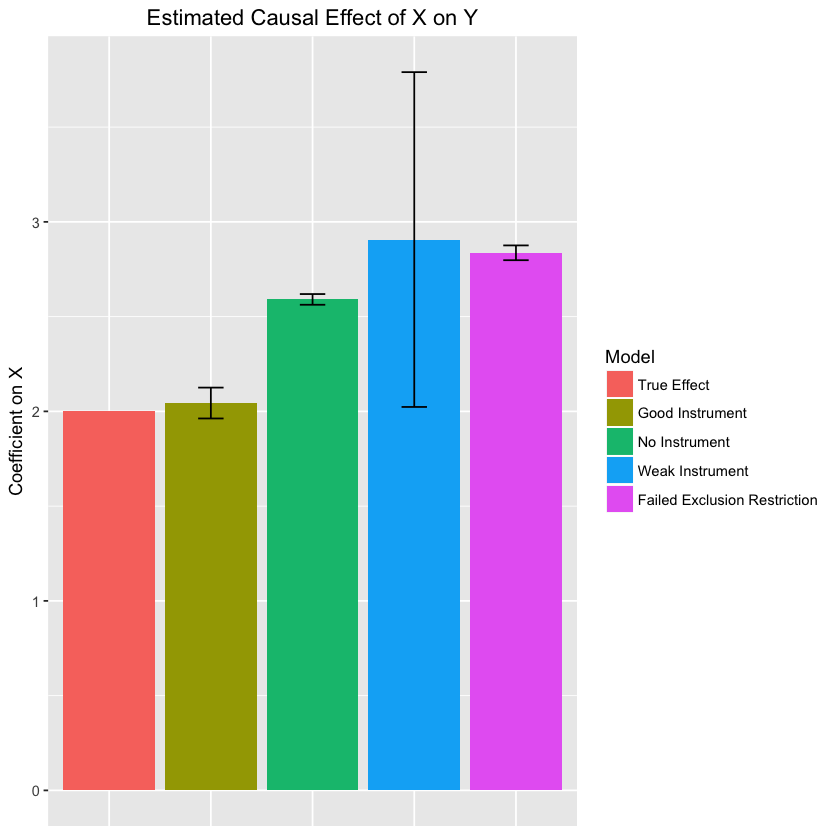

In [445]:
# Vector of T coefficients and confidence intervals
coefs.ab <- c(2.0, X.good, X.none, X.weak, X.correl)
ci.low <- c(NaN, ci.good[1], ci.none[1], ci.weak[1], ci.correl[1])
ci.high <- c(NaN, ci.good[2], ci.none[2], ci.weak[2], ci.correl[2])
dat <- cbind(coefs.ab, ci.low, ci.high, c('True Effect', 'Good Instrument', 'No Instrument', 'Weak Instrument', 'Failed Exclusion Restriction'))
colnames(dat)[4] <- 'Model'
dat <- data.frame(dat)
dat$coefs.ab <- as.double(levels(dat$coefs.ab))[dat$coefs.ab]
dat$ci.low <- as.double(levels(dat$ci.low))[dat$ci.low]
dat$ci.high <- as.double(levels(dat$ci.high))[dat$ci.high]
dat$Model <- factor(dat$Model, levels = dat$Model)

# Create bar graph
dodge <- position_dodge(width = 0.9)
limits <- aes(ymax = dat$ci.high,
              ymin = dat$ci.low)
p <- ggplot(data = dat, aes(x = Model, y = coefs.ab, fill = Model))
p + geom_bar(stat = "identity", position = dodge) +
  geom_errorbar(limits, position = dodge, width = 0.25) +
    ylab("Coefficient on X") +
    ggtitle("Estimated Causal Effect of X on Y") +
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(), 
        plot.title = element_text(hjust = 0.5))

# LASSO for Instrument Selection

In [446]:
# Clear workspace
rm(list=ls())
invisible(gc()) 

#Simulate Data
set.seed(1)
N <- 1e3 # Number of Observations
p <- 500 # Number of instruments (excluding unobservable)

# Generate matrix M of p randomly assigned AB tests
M <- matrix(0, N, p)
M[0:(N/2),] <- 1
M <- apply(t(M), 1, function(d) sample(d, N))
# Create an unobservable C
C <- rnorm(n = N)

# Create X as a function of weak instruments, good instruments, instruments that don't satisfy the exclusion restriction, and C
beta.X <- rnorm(p, mean = 0, sd = 5) * sign(rnorm(n = p))
beta.X[1:20] <- rnorm(20, mean = 1, sd = 4)
beta.X[21:25] <- 100
beta.X[201:p] <- 0
X <- M %*% beta.X + 120 * C + rnorm(n = N)
    
# Create Y as a function of X, C, and other variables that affect X
beta.Y <- rnorm(20, mean = 5, sd = 3) * sign(rnorm(n = 20))
Y <- 2.0 * X + 200 * C + rnorm(n = N) + M[, 1:20] %*% beta.Y
    
# Create data frames with and without variables that don't satisfy the exclusion restriction
colnames(M) <- colnames(data.frame('M' = M))
M.excl <- M[, 21:p]
df.allM <- data.frame('Y' = Y, 'X' = X, M)
df.excl <- data.frame('Y' = Y, 'X' = X, M.excl)

## LASSO X on M

In [447]:
lasso.fit <- cv.glmnet(M.excl, df.excl$X, alpha=1)
coef <- predict(lasso.fit, type = "nonzero")
M.excl.names <- colnames(M.excl)
Z <- M.excl.names[unlist(coef)]
# Instruments selected by LASSO:
length(Z)
Z

[1] 5

[1] "M.21" "M.22" "M.23" "M.24" "M.25"

In [448]:
# Run the IV
Z.list <- paste("~ ", paste(Z, collapse = " + "))
fit.lasso.excl <- ivreg(Y ~ X, Z.list, data = df.excl)
summary(fit.lasso.excl, vcov = sandwich, df = Inf, diagnostics = TRUE)
X.lasso.excl <- fit.lasso.excl$coefficients[2]
ci.lasso.excl <- confint(fit.lasso.excl, 'X', level = 0.95, vcov = sandwich)


Call:
ivreg(formula = Y ~ X | M.21 + M.22 + M.23 + M.24 + M.25, data = df.excl)

Residuals:
    Min      1Q  Median      3Q     Max 
-615.94 -130.35   -3.31  134.91  635.94 

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  7.37624   14.17835    0.52    0.603    
X            1.98078    0.05733   34.55   <2e-16 ***

Diagnostic tests:
                 df1 df2 statistic p-value    
Weak instruments   5 994   164.292  <2e-16 ***
Wu-Hausman         1 997  4199.733  <2e-16 ***
Sargan             4  NA     2.006   0.735    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 203.7 on Inf degrees of freedom
Multiple R-Squared: 0.8297,	Adjusted R-squared: 0.8295 
Wald test:  1194 on 1 DF,  p-value: < 2.2e-16 


In [449]:
# 1st Stage
firststage <- paste("X ~ ", paste(Z, collapse = " + "))
fit.firststage <- lm(firststage, data = df.excl)
summary(fit.firststage)


Call:
lm(formula = firststage, data = df.excl)

Residuals:
    Min      1Q  Median      3Q     Max 
-397.84  -83.23   -3.36   83.53  365.24 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -18.561      9.538  -1.946   0.0519 .  
M.21          95.071      7.838  12.129   <2e-16 ***
M.22         108.329      7.854  13.792   <2e-16 ***
M.23          88.480      7.848  11.274   <2e-16 ***
M.24          97.049      7.850  12.363   <2e-16 ***
M.25          97.148      7.833  12.402   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 123.7 on 994 degrees of freedom
Multiple R-squared:  0.4403,	Adjusted R-squared:  0.4375 
F-statistic: 156.4 on 5 and 994 DF,  p-value: < 2.2e-16


In [450]:
# No instruments
fit.noinst <- lm(Y ~ X, data = df.allM)
X.noinst <- fit.noinst$coefficients[2]
ci.noinst <- confint(fit.noinst, 'X', level = 0.95)

# Largest subset of all possible IV
M.names <- colnames(M)
M.largest.list <- paste("~ ", paste(M.names[1:p], collapse = " + "))
fit.largest <- ivreg(Y ~ X, M.largest.list, data = df.allM)
X.largest <- fit.largest$coefficients[2]
ci.largest <- confint(fit.largest, 'X', level = 0.95, vcov = sandwich)

Warning message in data.row.names(row.names, rowsi, i):
“some row.names duplicated: 3,4 --> row.names NOT used”Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

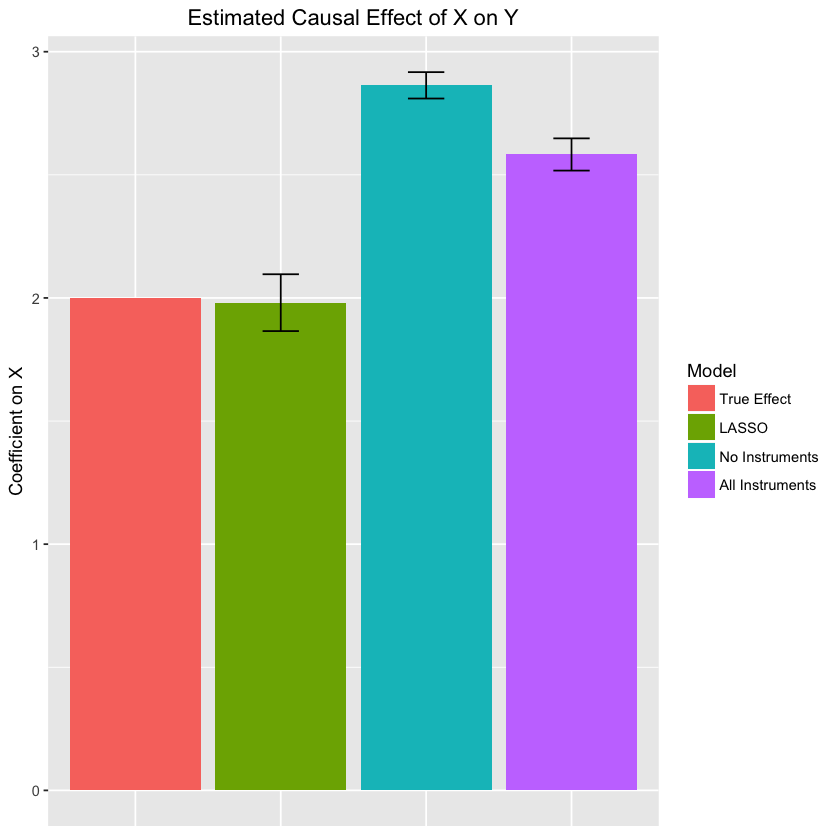

In [452]:
# Vector of T coefficients and confidence intervals
coefs.ab <- c(2.0, X.lasso.excl, X.noinst, X.largest)
ci.low <- c(NaN, ci.lasso.excl[1], ci.noinst[1], ci.largest[1])
ci.high <- c(NaN, ci.lasso.excl[2], ci.noinst[2], ci.largest[2])
dat <- cbind(coefs.ab, ci.low, ci.high, c('True Effect', 'LASSO','No Instruments',
                                          'All Instruments'))
colnames(dat)[4] <- 'Model'
dat <- data.frame(dat)
dat$coefs.ab <- as.double(levels(dat$coefs.ab))[dat$coefs.ab]
dat$ci.low <- as.double(levels(dat$ci.low))[dat$ci.low]
dat$ci.high <- as.double(levels(dat$ci.high))[dat$ci.high]
dat$Model <- factor(dat$Model, levels = dat$Model)

# Create bar graph
dodge <- position_dodge(width = 0.9)
limits <- aes(ymax = dat$ci.high,
              ymin = dat$ci.low)
p <- ggplot(data = dat, aes(x = Model, y = coefs.ab, fill = Model))
p + geom_bar(stat = "identity", position = dodge) +
  geom_errorbar(limits, position = dodge, width = 0.25) +
    ylab("Coefficient on X") +
    ggtitle("Estimated Causal Effect of X on Y") +
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(), 
        plot.title = element_text(hjust = 0.5))